In [1]:
# Press CTRL-Enter to run this cell!
!pip list | grep tensorflow

mesh-tensorflow          0.0.5                
tensorflow               1.14.0               
tensorflow-estimator     1.14.0               
tensorflow-hub           0.6.0                
tensorflow-metadata      0.14.0               
tensorflow-probability   0.7.0                


In [2]:
!pip install tensorflow-gpu==2.0.0-b1

     |████████████████████████████████| 348.9MB 81kB/s 
     |████████████████████████████████| 3.1MB 61.0MB/s 
     |████████████████████████████████| 501kB 67.1MB/s 


In [0]:
import random
import time
import math

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

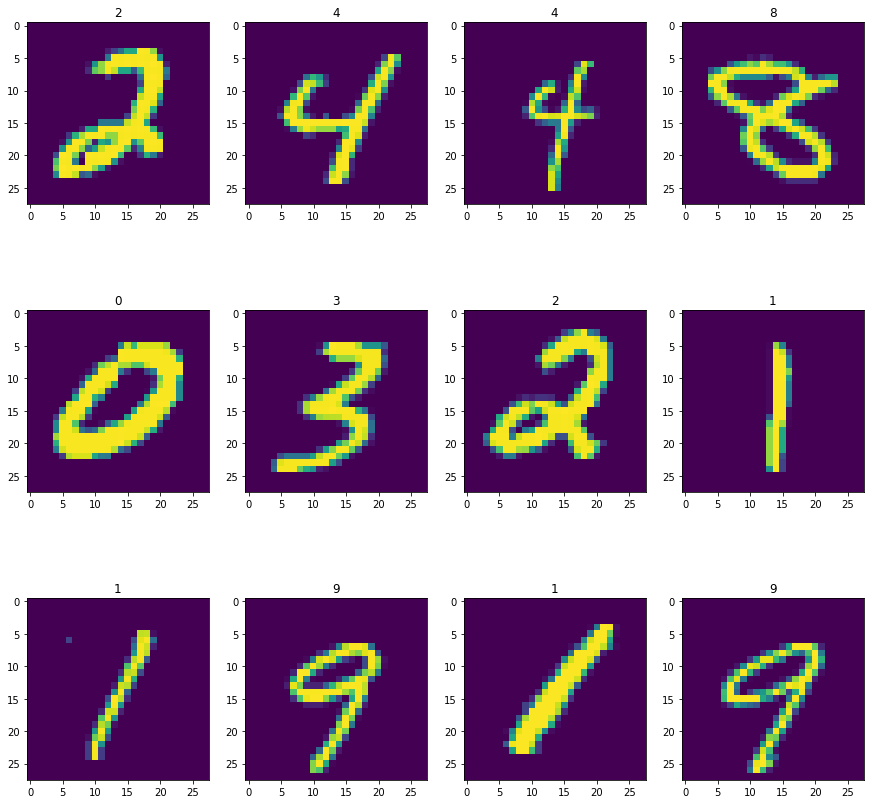

In [26]:
rows=3
cols=4
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
for i in range(rows):
  for j in range(cols):
    idx = random.randint(0, x_train.shape[0]-1)
    axs[i,j].imshow(x_train[idx,...])
    axs[i,j].set_title(f"{y_train[idx]}")
plt.show()

In [27]:
def preprocess(imgs):
  return (imgs.astype(np.float32) / 255).reshape((imgs.shape[0], 28, 28, 1))

# Preprocess data here.
x_train, x_val = preprocess(x_train), preprocess(x_val)
y_train = tf.one_hot(y_train, 10)    #one hot encoding
y_val = tf.one_hot(y_val, 10)
y_train[:5]

<tf.Tensor: id=3958453, shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [28]:
print(f"Training Image Shape: {x_train.shape}")
print(f"Training Label Shape: {y_train.shape}")

Training Image Shape: (60000, 28, 28, 1)
Training Label Shape: (60000, 10)


In [0]:
EPOCHS = 3
BATCH_SIZE = 32

In [30]:
def create_tf_dataset(*np_arrays):
  dset = tf.data.Dataset.from_tensor_slices(np_arrays)
  dset = dset.shuffle(np_arrays[0].shape[0]+1)
  dset = dset.batch(BATCH_SIZE)
  return dset

# Create datasets here (batches of 32 -> tensor flow data set)
train_dataset = create_tf_dataset(x_train, y_train)
val_dataset = create_tf_dataset(x_val, y_val)
train_dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

In [0]:
from tensorflow.keras.layers import Conv2D, Activation, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
      Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(.001)),
      Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(.001)),
      Dropout(0.25),
      Flatten(),
      Dense(128, activation='relu', kernel_regularizer=l2(.001)),
      Dropout(0.5),
      Dense(10, activation='softmax', kernel_regularizer=l2(.001)),
])

In [0]:
# Create optimizer here.
optimizer = tf.keras.optimizers.Adam()

In [0]:
train_accuracies = []
val_accuracies = []
batch_count = math.ceil(x_train.shape[0]/BATCH_SIZE)

In [34]:
for epoch in range(EPOCHS):
  train_loss = tf.keras.metrics.Mean("train_loss")
  train_acc = tf.keras.metrics.CategoricalAccuracy("train_acc")
  progbar = tf.keras.utils.Progbar(batch_count)
  start_time = time.time()
  for batch, (images, true_labels) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      predicted_labels = model(images, training=True)
      loss = tf.keras.losses.categorical_crossentropy(true_labels, predicted_labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_acc(true_labels, predicted_labels)
    progbar.update(batch)
  train_accuracies.append(train_acc.result())
  end_time = time.time()
  
  val_loss = tf.keras.metrics.Mean("val_loss")
  val_acc = tf.keras.metrics.CategoricalAccuracy("val_acc")
  for images, true_labels in val_dataset:
    predicted_labels = model(images, training=False)
    loss = tf.keras.losses.categorical_crossentropy(true_labels, predicted_labels)
    val_loss(loss)
    val_acc(true_labels, predicted_labels)
  val_accuracies.append(val_acc.result())
  
  print(f" Epoch {epoch+1}, Train_Loss {train_loss.result()}, Val_Loss {val_loss.result()} Train_Time {end_time - start_time}")
    
    

1874/1875 [============================>.] - ETA: 0s Epoch 3, Train_Loss 0.055203743278980255, Val_Loss 0.03728851303458214 Train_Time 40.562578201293945


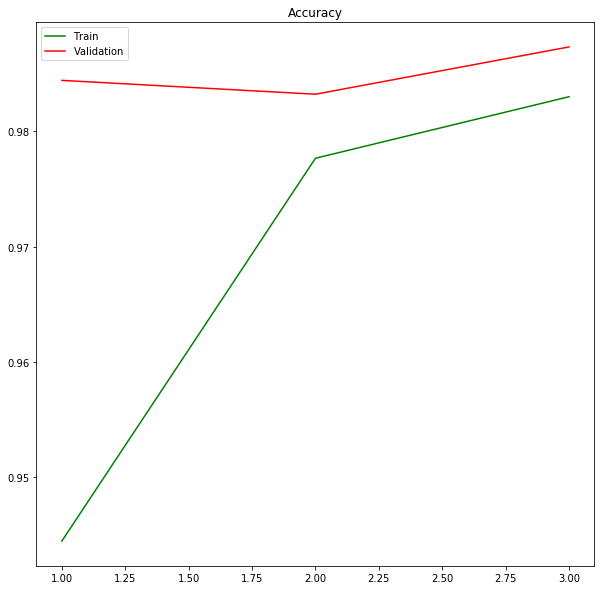

In [35]:
train_accuracies = np.asarray(train_accuracies)
val_accuracies = np.asarray(val_accuracies)
epochs = np.arange(1, EPOCHS+1)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(epochs, train_accuracies, color="g", label="Train")
ax.plot(epochs, val_accuracies, color="r", label="Validation")
plt.title("Accuracy")
ax.legend()
plt.show()

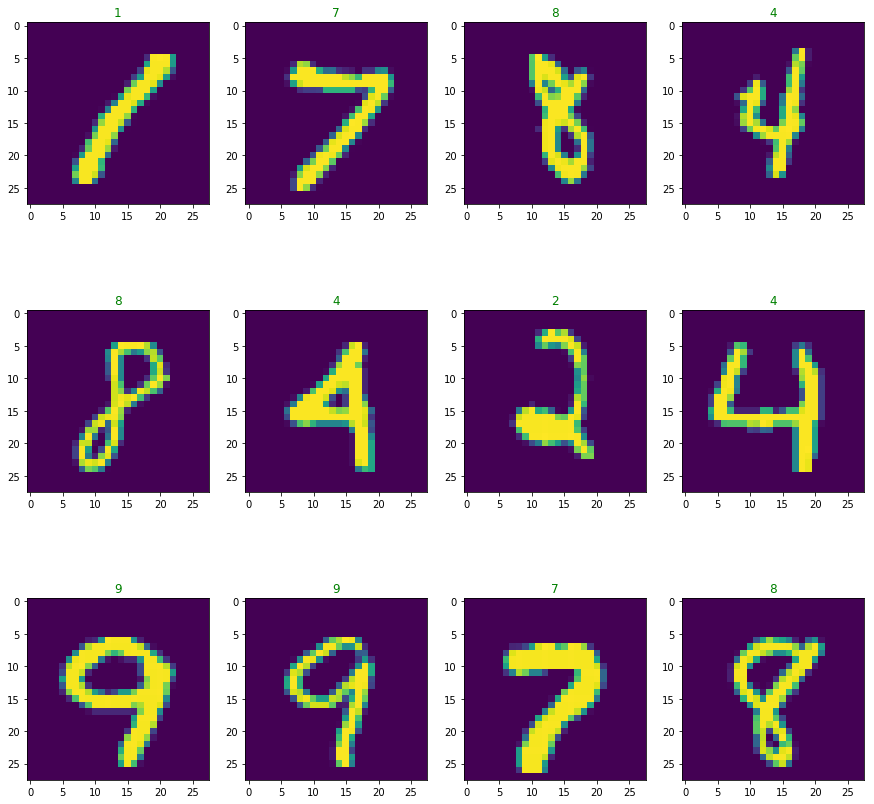

In [36]:
rows=3
cols=4
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
for i in range(rows):
  for j in range(cols):
    idx = random.randint(0, x_val.shape[0]-1)
    axs[i,j].imshow(x_val[idx,...].reshape(28, 28))
    predicted_distribution = model(np.expand_dims(x_val[idx,...],0), training=False)
    predicted_label = int(tf.argmax(predicted_distribution, axis=1))
    true_label = int(np.argmax(y_val[idx]))
    color = "green" if predicted_label == true_label else "red"
    axs[i,j].set_title(f"{predicted_label}", color=color)
plt.show()

In [37]:
print(f"Final training accuracy: {train_accuracies[-1]}")
print(f"Final validation accuracy: {val_accuracies[-1]}")

Final training accuracy: 0.9829833507537842
Final validation accuracy: 0.9872999787330627
